In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df.shape

(404290, 6)

In [4]:
df.info()

## seems like question 1 and question 2 has some null entries in it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
## lets see any duplicated values in it or not
df.duplicated().sum()

## no duplicate values

0

In [7]:
df['is_duplicate'].value_counts()

## 0 means non-duplicate questions
## 1 means duplicate questions

0    255027
1    149263
Name: is_duplicate, dtype: int64

<AxesSubplot:>

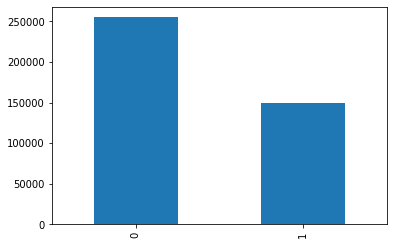

In [7]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [8]:
## lets seee the % distribution of the dataset
(df['is_duplicate'].value_counts() / df['is_duplicate'].count())*100

## seems to be somewhat u nbalance in the dataset 


0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

In [11]:
## exmaple of list addition
a = [1,2,3]
b = [2]
print(b+a)
a+b

[2, 1, 2, 3]


[1, 2, 3, 2]

In [17]:
## out of all the question in qid1 and qid2, lets see how many are unique
# qid1, qid2 - unique ids of each question (only available in train.csv)

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

print("size of qid: ", qid.shape)
print("number of unique questions: ", np.unique(qid).shape)


## if question getting repeated, the id will repeat and hence qid_id will have count > 1
print("repeating questions: ", (qid.value_counts()>1).sum())

size of qid:  (808580,)
number of unique questions:  (537933,)
repeating questions:  111780


In [22]:
qid.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [11]:
qid.value_counts().values

array([157, 120, 111, ...,   1,   1,   1], dtype=int64)

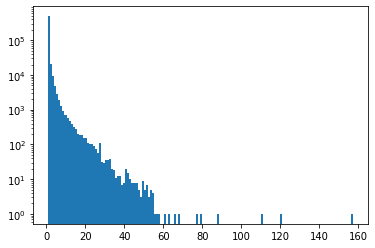

In [12]:
plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')

## 160 has just line till 1 on y 
## so it means theres a single question that has appeared 160 times

## IDEA 01

Lets consider question1 and question2 as bag of words and then apply the Random Forest model on full dataset.


In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
df.shape

## its around 0.4 million rows
## it will take a huge time on this laptop to get the result
## so we will use just 30,000 rows which will be selected randomly

(404290, 6)

In [35]:
new_df = df.sample(30000)

new_df['is_duplicate'].value_counts()

## still somewhat data imbalance

0    19062
1    10938
Name: is_duplicate, dtype: int64

In [36]:
new_df.isnull().sum()

## no nulll values

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [37]:
new_df.duplicated().sum()
## no duplicate values

0

In [38]:
## lets see how many repeated questions are there in the new_df dataframes

qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())

print("Unique questions: ",np.unique(qid).shape[0])

print("Repeated questions: ", (qid.value_counts()>1).sum())

Unique questions:  55551
Repeated questions:  3421


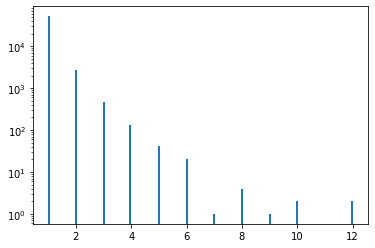

In [39]:
## Repeated questions histogram

plt.hist(qid.value_counts(),bins=150)
plt.yscale('log')

In [40]:
## lets use the count vectorizer thing
from sklearn.feature_extraction.text import CountVectorizer

questions = list(new_df['question1']) + list(new_df['question2'])
## by this we got the bag of words

## just took the starting 3000 words
cv = CountVectorizer(max_features=3000,stop_words='english')
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [44]:
q1_arr.shape
## 30k questions, but only 3k features 

(30000, 3000)

In [45]:
temp_df1 = pd.DataFrame(q1_arr, index = new_df.index)
temp_df2 = pd.DataFrame(q2_arr, index = new_df.index)

###########

## next step because there are same col names in the dataset
## and while doing the xg-boost thing,  error is coming for same names

q=[]
for i in temp_df2.columns:
    q.append(str(i)+"_")

temp_df2.columns = q
################################
temp_df = pd.concat([temp_df1,temp_df2],axis=1)

temp_df.shape

## 30,000 questions
## total features were 3000, so for 2 questions columns: total 6000 cols

(30000, 6000)

In [46]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [47]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991_,2992_,2993_,2994_,2995_,2996_,2997_,2998_,2999_,is_duplicate
278519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
191315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Lets apply Random Forest

In [48]:
from sklearn.model_selection import train_test_split
X = temp_df.drop('is_duplicate',axis=1)
y = temp_df['is_duplicate']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
accuracy_score(y_test,y_pred)

## just 69.25% accuracy on it

0.6923333333333334

In [50]:
## lets dump the model using pickle
import pickle

RandomForest = 'RandomForest.sav'
pickle.dump(rf, open(RandomForest, 'wb'))

In [51]:
## so from next time, just use the pickel model to load the model
loaded_model = pickle.load(open(RandomForest, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6923333333333334


### XGBOOST

In [52]:

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_pred,y_test)

## acc of 71.43%

[18:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7186666666666667

## Pickle Dump for xgboost

In [54]:
## lets dump the model using pickle
import pickle

xgboost = 'XGBoost.sav'
pickle.dump(xgb, open(xgboost, 'wb'))


## loading the model
loaded_model = pickle.load(open(xgboost, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7186666666666667


In [55]:
X_train.columns.duplicated().sum()
## no duplicate cols in the x_train one

0

## Lets do some Feature Engineering

q1_len : Char len of q1

q2_len : char len of q2

q1_words : total words in q1

q2_words: total words in q2

words_common : common words in both

words_total : total words in q1 and q2

word_share : word_common / word_total

In [56]:
## len of the question
new_df['q1_len']=new_df['question1'].str.len()
new_df['q2_len']=new_df['question2'].str.len()

In [57]:
## total words in

new_df['q1_words'] = new_df['question1'].apply(lambda x: len(x.split(" ")))
new_df['q2_words'] = new_df['question2'].apply(lambda x: len(x.split(" ")))

In [63]:
a = ['sanket','zanwar']
b = ['shankii','zanwar']

print(a and b)  ## b is retured, see the below link
set(a) & set(b)

## https://www.geeksforgeeks.org/g-fact-43-logical-operators-on-string-in-python/#:~:text=For%20strings%20in%20python%2C%20boolean,Python3


['shankii', 'zanwar']


{'zanwar'}

In [58]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return len(w1 & w2)

## same as
#def common_words(row):
 #   w1 = set(row['question1'].lower().strip().split(" "))
 #  w2 = set(row['question2'].lower().strip().split(" "))
 #   return len(w1 & w2) 
       

In [59]:
new_df['common_words'] = new_df.apply(common_words,axis=1)

In [64]:
def total_words(row):
    w1 = set(row['question1'].lower().strip().split(" "))
    w2 = set(row['question2'].lower().strip().split(" "))
    return (len(w1) + len(w2))

In [65]:
new_df['total_words'] = new_df.apply(total_words,axis=1)

In [66]:
new_df['word_share'] = np.round(new_df['common_words'] / new_df['total_words'],2)

In [67]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,total_words,word_share
278519,278519,397801,397802,What would your advice be for a recent graduat...,I own a very new cat tower/mansion business. S...,0,85,150,16,24,1,37,0.03
129742,129742,208350,208351,A lemon kept in water in a glass tumbler appea...,Why does a lemon kept in a glass of water susp...,0,134,50,27,11,8,35,0.23
337964,337964,465481,465482,Why does high protein diet cause gas?,Why does protein cause farts?,1,37,29,7,5,4,12,0.33
191315,191315,290618,290619,Are my parents strict?,"My parents are really strict, what do I do?",0,22,43,4,9,3,13,0.23
38798,38798,70418,70419,Are the US universities planning to stop givin...,How difficult is it to get a scholarship for a...,0,126,168,21,29,5,47,0.11


## EDA

min chars:  2
max chars:  334
avg chars:  59.5761


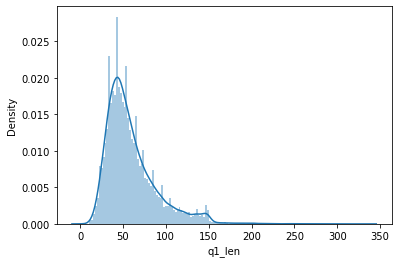

In [68]:
sns.distplot(new_df['q1_len'],bins=150)
print("min chars: ",new_df['q1_len'].min())
print("max chars: ",new_df['q1_len'].max())
print("avg chars: ",new_df['q1_len'].mean())

## clearly you can see there are some outliers in the dataset 
## min chars as 1 and max chars as 370
## seems somewhat odd

min chars:  3
max chars:  1169
avg chars:  60.04593333333333


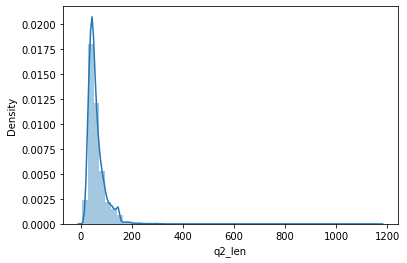

In [33]:
sns.distplot(new_df['q2_len'],bins=50)
print("min chars: ",new_df['q2_len'].min())
print("max chars: ",new_df['q2_len'].max())
print("avg chars: ",new_df['q2_len'].mean())


## clearly you can see there are some outliers in the dataset 
## min chars as 2 and max chars as 1115
## seems somewhat odd

minimum words 1
maximum words 67
average num of words 10


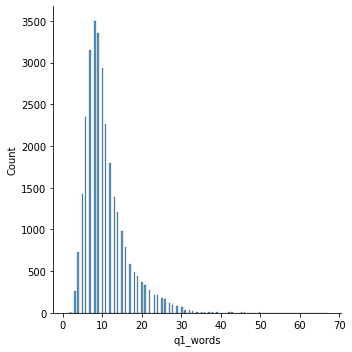

In [69]:
sns.displot(new_df['q1_words'])
print('minimum words',new_df['q1_words'].min())
print('maximum words',new_df['q1_words'].max())
print('average num of words',int(new_df['q1_words'].mean()))

## same case here: outliers also

minimum words 1
maximum words 228
average num of words 11


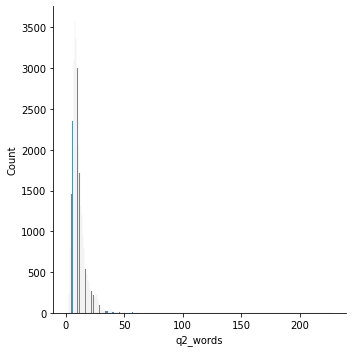

In [35]:
sns.displot(new_df['q2_words'])
print('minimum words',new_df['q2_words'].min())
print('maximum words',new_df['q2_words'].max())
print('average num of words',int(new_df['q2_words'].mean()))

## same case here: outliers also

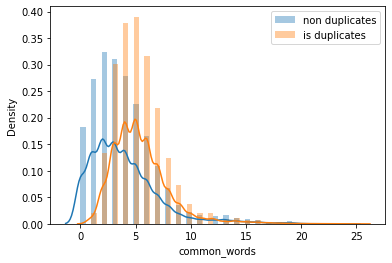

In [70]:
## lets see the similarity between the words_common and is_duplicate column

sns.distplot(new_df[new_df['is_duplicate']==0]['common_words'], label = 'non duplicates')
sns.distplot(new_df[new_df['is_duplicate']==1]['common_words'], label = 'is duplicates')
plt.legend()
plt.show()

## you can see here: if the common words < 3 : its non-duplicate question
## if common words > 3 : its duplicate question


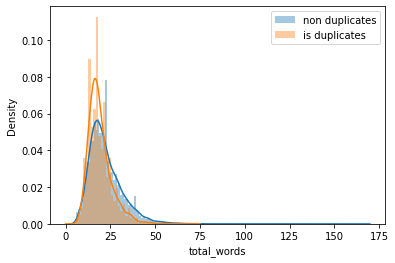

In [37]:
## lets see the similarity between the total_words and is_duplicate column

sns.distplot(new_df[new_df['is_duplicate']==0]['total_words'], label = 'non duplicates',bins=150)
sns.distplot(new_df[new_df['is_duplicate']==1]['total_words'], label = 'is duplicates')
plt.legend()
plt.show()


## if total words > 25: non-duplicate probabillity is more
## if total words < 25 : duplicate probability is more


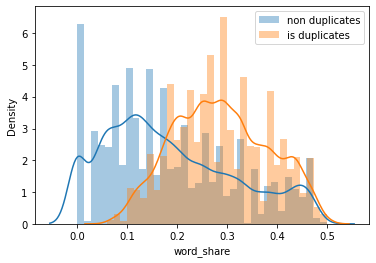

In [71]:
## lets see the similarity between the word_share and is_duplicate column

sns.distplot(new_df[new_df['is_duplicate']==0]['word_share'], label = 'non duplicates')
sns.distplot(new_df[new_df['is_duplicate']==1]['word_share'], label = 'is duplicates')
plt.legend()
plt.show()

## if > 0.2 : more chances of duplicated question


In [72]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
278519,What would your advice be for a recent graduat...,I own a very new cat tower/mansion business. S...
129742,A lemon kept in water in a glass tumbler appea...,Why does a lemon kept in a glass of water susp...
337964,Why does high protein diet cause gas?,Why does protein cause farts?
191315,Are my parents strict?,"My parents are really strict, what do I do?"
38798,Are the US universities planning to stop givin...,How difficult is it to get a scholarship for a...


In [73]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()


(30000, 8)


,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,total_words,word_share
278519,0,85,150,16,24,1,37,0.03
129742,0,134,50,27,11,8,35,0.23
337964,1,37,29,7,5,4,12,0.33
191315,0,22,43,4,9,3,13,0.23
38798,0,126,168,21,29,5,47,0.11


In [74]:
## now lets join temp_df and final_df
## temp_df is the dataset we have got by using the bag of words and all on the question1 and question2 column

temp_df.drop('is_duplicate',axis=1,inplace=True)
final_df = pd.concat([final_df,temp_df],axis=1)
final_df.head()



,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,total_words,word_share,0,1,...,2990_,2991_,2992_,2993_,2994_,2995_,2996_,2997_,2998_,2999_
278519,0,85,150,16,24,1,37,0.03,0,0,...,0,0,0,0,0,0,0,0,0,0
129742,0,134,50,27,11,8,35,0.23,0,0,...,0,0,0,0,0,0,0,0,0,0
337964,1,37,29,7,5,4,12,0.33,0,0,...,0,0,0,0,0,0,0,0,0,0
191315,0,22,43,4,9,3,13,0.23,0,0,...,0,0,0,0,0,0,0,0,0,0
38798,0,126,168,21,29,5,47,0.11,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
from sklearn.model_selection import train_test_split
X = final_df.drop('is_duplicate',axis=1)
y = final_df['is_duplicate']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,)


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

## without adding features it was giving the accuracy of 69

0.767

In [80]:
## pickle dump

import pickle

Rf_feature_selection = 'Rf_feature_selection.sav'
pickle.dump(rf, open(Rf_feature_selection, 'wb'))


## loading the model
loaded_model = pickle.load(open(Rf_feature_selection, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.767


In [81]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_pred,y_test)

[18:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7531666666666667

In [83]:
## lets dump the model using pickle
import pickle

xgboost_feature_selection = 'XGBoost_feature_selection.sav'
pickle.dump(xgb, open(xgboost_feature_selection, 'wb'))


## loading the model
loaded_model = pickle.load(open(xgboost_feature_selection, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7531666666666667


## Adding Extra Features for Advanced Feature Engineering

## Token features

-> cwc_min: This is the ratio of the number of common words to the length of the smaller question

-> cwc_max: This is the ratio of the number of common words to the length of the larger question

-> csc_min: This is the ratio of the number of common stop words to the minimum stop word count among the two questions

-> csc_max: This is the ratio of the number of common stop words to the maximum stop word count among the two questions

-> ctc_min: This is the ratio of the number of common tokens to the minimum token count among the two questions

-> ctc_max: This is the ratio of the number of common tokens to the maximum token count among the two questions

-> last_word_eq: 1 if the last word in the two questions is same, 0 otherwise

-> first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

## Length Based Features

-> mean_len: Mean of the length of the two questions (number of words)

-> abs_len_diff: Absolute difference between the length of the two questions (number of words)

-> longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question


## Fuzzy Features

## https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

-> fuzz_ratio: fuzz_ratio score from fuzzywuzzy library

-> fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy library

-> token_sort_ratio: token_sort_ratio from fuzzywuzzy library

-> token_set_ratio: token_set_ratio from fuzzywuzzy